# First version of AE with clustering loss

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement csv (from versions: none

In [2]:
from keras import layers
from keras.layers import Layer
from keras.models import load_model, Model
from keras import backend as K
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import datetime
import time
import os
import csv
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.metrics.pairwise import euclidean_distances

2024-06-14 08:59:32.933275: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 08:59:34.137315: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 08:59:45.012135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 09:02:50.123277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__

'2.16.1'

In [4]:
keras.__version__

'3.3.3'

## Preprocessing

### Load dataset

On importe le dataset baron et on applique le prétraitement habituel

In [5]:
filename="./dataset/barondata_rawcounts.csv"
data_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
data_baron

,human1_lib1.final_cell_0001,human1_lib1.final_cell_0002,human1_lib1.final_cell_0003,human1_lib1.final_cell_0004,human1_lib1.final_cell_0005,human1_lib1.final_cell_0006,human1_lib1.final_cell_0007,human1_lib1.final_cell_0008,human1_lib1.final_cell_0009,human1_lib1.final_cell_0010,...,human4_lib3.final_cell_0692,human4_lib3.final_cell_0693,human4_lib3.final_cell_0694,human4_lib3.final_cell_0695,human4_lib3.final_cell_0696,human4_lib3.final_cell_0697,human4_lib3.final_cell_0698,human4_lib3.final_cell_0699,human4_lib3.final_cell_0700,human4_lib3.final_cell_0701
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,4,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,0,1,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
ZYX,2,4,0,3,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
ZZEF1,0,0,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ZZZ3,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
filename="./dataset/barondata_annotations.csv"
annotations_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
annotations_baron

,donor,label
human1_lib1.final_cell_0001,GSM2230757,acinar
human1_lib1.final_cell_0002,GSM2230757,acinar
human1_lib1.final_cell_0003,GSM2230757,acinar
human1_lib1.final_cell_0004,GSM2230757,acinar
human1_lib1.final_cell_0005,GSM2230757,acinar
...,...,...
human4_lib3.final_cell_0697,GSM2230760,activated_stellate
human4_lib3.final_cell_0698,GSM2230760,alpha
human4_lib3.final_cell_0699,GSM2230760,beta
human4_lib3.final_cell_0700,GSM2230760,beta


In [7]:
data_ann=sc.AnnData(data_baron.T)
data_ann

AnnData object with n_obs × n_vars = 8569 × 20125

In [8]:
data_ann.obs['label'] = annotations_baron['label']

### Filter data

On filtre les données de manière peu stricte

In [9]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

In [10]:
data_ann.raw = data_ann.copy()

In [11]:
data_ann

AnnData object with n_obs × n_vars = 8569 × 17499
    obs: 'label', 'n_genes'
    var: 'n_cells'

### Normalize and scale

In [12]:
sc.pp.normalize_total(data_ann)
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0
sc.pp.log1p(data_ann)


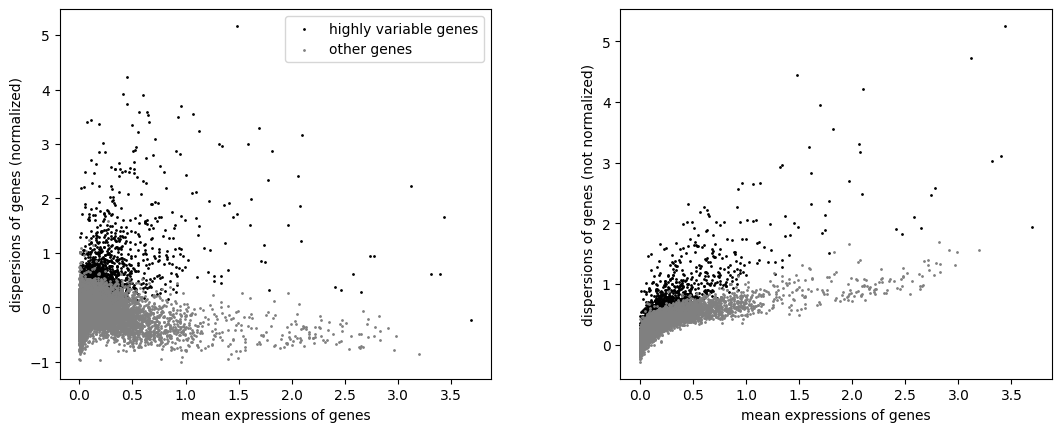

In [13]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [14]:
sc.pp.scale(data_ann)

### Explore the result

In [15]:
data_ann.X

array([[-0.06469017,  1.563252  , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.31848672],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [16]:
data_ann.n_vars

17499

In [17]:
data_ann.X

array([[-0.06469017,  1.563252  , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.31848672],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [18]:
data_ann.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
A1BG,42,False,0.011018,-0.025517,-0.574290,1,False,0.003199,0.049455
A1CF,1408,False,0.140704,0.230606,-0.024027,1,False,0.132453,0.327797
A2M,273,False,0.162812,0.371500,0.196539,3,False,0.029914,0.180720
A4GALT,444,False,0.134773,0.333580,0.060687,3,False,0.043716,0.203291
AAAS,1216,True,0.183781,0.576148,0.473154,6,False,0.104913,0.285008
...,...,...,...,...,...,...,...,...,...
ZYG11B,1394,False,0.192391,0.371347,-0.082705,1,False,0.119749,0.299532
ZYX,2691,False,0.572281,0.582603,-0.147203,2,False,0.289623,0.489316
ZZEF1,1225,False,0.144169,0.421400,0.217033,2,False,0.106196,0.283994
ZZZ3,872,False,0.120500,0.381103,0.083912,1,False,0.074865,0.243036


In [19]:
data_ann.obs

,label,n_genes,size_factors
human1_lib1.final_cell_0001,acinar,3526,1.909042
human1_lib1.final_cell_0002,acinar,4201,2.274499
human1_lib1.final_cell_0003,acinar,2119,1.147266
human1_lib1.final_cell_0004,acinar,2956,1.600433
human1_lib1.final_cell_0005,acinar,2715,1.469951
...,...,...,...
human4_lib3.final_cell_0697,activated_stellate,1055,0.571197
human4_lib3.final_cell_0698,alpha,1007,0.545208
human4_lib3.final_cell_0699,beta,942,0.510016
human4_lib3.final_cell_0700,beta,1031,0.558202


In [20]:
data_ann.raw.X

array([[0, 4, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 ,  0.31848672],
       [-0.36810586,  0.04432194, -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586,  0.3338874 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       ...,
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617]], dtype=float32)

In [22]:
raw_count_hvg=data_ann.raw[:,highly_variable_genes].X

## Create autoencoder

In [23]:
def create_contrastive_encoder(input_dim, dims, dropout=0.8):
    Inputs = layers.Input(shape=(input_dim,))
    x = layers.Dropout(rate=dropout)(Inputs)  # L'argument input_shape n'est pas nécessaire ici
    for i in range(len(dims) - 1):
        x = layers.Dense(dims[i], kernel_initializer='glorot_uniform')(x)
        x = layers.BatchNormalization(epsilon=1e-5, momentum=0.1)(x)
        x = layers.ReLU()(x)
    
    # Dernière couche sans activation pour obtenir les embeddings
    x = layers.Dense(dims[-1],  kernel_initializer='glorot_uniform')(x)
    x = layers.Lambda(lambda y: tf.nn.l2_normalize(y, axis=1))(x)
    model = Model(Inputs, x)
    return model

In [24]:
def SupConLoss(features, labels=None, mask=None, temperature=0.07, base_temperature=0.07, contrast_mode='all'): 
    if len(features.shape) < 3:
        raise ValueError('`features` needs to be [bsz, n_views, ...], at least 3 dimensions are required')
    if len(features.shape) > 3:
        features = tf.reshape(features, [tf.shape(features)[0], tf.shape(features)[1], -1]) 
    batch_size = tf.shape(features)[0]
    if labels is not None and mask is not None:
        raise ValueError('Cannot define both `labels` and `mask`')
    elif labels is None and mask is None:
        mask = tf.eye(batch_size, dtype=tf.float32)
    elif labels is not None:
        labels = tf.reshape(labels, (-1, 1))
        if labels.shape[0] != batch_size:
            raise ValueError('Num of labels does not match num of features')
        mask = tf.cast(tf.equal(labels, tf.transpose(labels)), dtype=tf.float32)
    else:
        mask = tf.eye(batch_size, dtype=tf.float32)
    contrast_count = features.shape[1]
    contrast_feature = tf.reshape(tf.concat(tf.unstack(features, axis=1), axis=0), [-1, tf.shape(features)[2]])
    if contrast_mode == 'one':
        anchor_feature = features[:, 0]
        anchor_count = 1
    elif contrast_mode == "all":
        anchor_feature = contrast_feature
        anchor_count = contrast_count
    else:
        raise ValueError(f'Unknown mode : {contrast_mode}')
        
    anchor_dot_contrast = tf.math.divide(tf.linalg.matmul(anchor_feature, contrast_feature, transpose_b=True), temperature)
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    mask = tf.tile(mask, [anchor_count, contrast_count])
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size * anchor_count, dtype=tf.float32)
    mask *= logits_mask
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)

    loss = -(temperature / base_temperature) * mean_log_prob_pos
    loss = tf.reshape(loss, [anchor_count, batch_size])
    loss = tf.reduce_mean(loss)

    return loss

In [25]:
def auto_kmeans(encoder, x_counts, obs,n='auto',  plot=False):
    y=obs
    ari=[]
    nmi=[]
    ca=[]
    x=[]
    if n=="auto":
        for n in range (1,20):
            kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
            y_pred=kmeans.fit_predict(encoder.predict(x_counts, verbose=0))
            ari.append(adjusted_rand_score(y, y_pred))
            nmi.append(normalized_mutual_info_score(y, y_pred))
            ca.append(cluster_acc(y, y_pred))
            x.append(n)
        somme_metriques = [x + y + z for x, y, z in zip(ari, nmi, ca)]
        n_max=(somme_metriques.index(max(somme_metriques))+1)
    
    kmeans=KMeans(n_clusters=n_max, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict(x_counts))
    
    if plot==True:
        predict_data=encoder.predict(x_counts)
        adata_latent = sc.AnnData(predict_data)
        obs_df = pd.DataFrame({'label': y})
        adata_latent.obs=obs_df
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.plot(x,nmi)
        plt.plot(x,ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, y_pred)
        print("Clustering accuracy (CA) :", ca)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n_max, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, y, res="auto", plot=False):
    predict_data=encoder.predict(x_counts, verbose=0)
    adata_latent = sc.AnnData(predict_data)
    obs_df = pd.DataFrame({'label': y})
    adata_latent.obs=obs_df
    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    list_ca=[]
    x=[]
    
    if res=="auto":
        #search for the best resolution
        for i in range (1,10):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/100)
        for i in range (1,11):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/10)
        somme_metriques = [x + y + z for x, y, z in zip(list_ari, list_nmi, list_ca)]
        res=x[somme_metriques.index(max(somme_metriques))]
        print("La résolution est de : ", res)
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)
    predict=adata_latent.obs["leiden_res_%.4f" % (res)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #set of plot if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.plot(x,list_nmi)
        plt.plot(x,list_ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        plt.plot()
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res)], legend_loc="on data")
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, predict)
        print("Clustering accuracy (CA) :", ca)
 
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return res, predict, n_clusters, cluster_centers

def cluster_embedding(model, X, y, method=None, res='auto', n='auto', plot=False):
    if method=='leiden':
        res, predict, n_clusters, cluster_centers=auto_leiden(encoder=model, x_counts=X, y=y, res=res, plot=plot)
        return res, predict, n_clusters, cluster_centers
    elif method=='kmeans':
        y_pred, n_max, cluster_centers=auto_kmeans(encoder=model, x_counts=X, obs=y,n=n,  plot=plot)
        return res, y_pred, n_max, cluster_centers
    else:
        raise ValueError(f'Unknown method : {method}')
    

In [26]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    # Assurez-vous que les étiquettes sont de type str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # Trouver les étiquettes uniques
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Construire la matrice de coût (matrice de confusion)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    # Résoudre le problème de correspondance bipartite optimal
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Calculer la précision
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy


In [27]:
def save_results_to_csv(history, filename):
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(history.keys())
        writer.writerow(history.values())
        
def check_existing_filename(filename):
    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(filename):
        filename = f"{base}_{counter}{ext}"
        counter += 1
    return filename

def save_plot_umap(model, x, y, y_pred, res, epoch, pdf_pages, train_val="train"):
    #Récupération des données et projection dans l'espace latent 
    predict_data=model.predict(x, verbose=0)
    obs_df = pd.DataFrame({'label': y})
    
    #Préparation des données pour Scanpy
    adata_latent = sc.AnnData(X=predict_data)
    adata_latent.obs = obs_df
    adata_latent.obs['predict'] = y_pred.astype(str)

    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    
    # Génération du UMAP avec Scanpy
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata_latent, color='label', ax=axs[0], show=False)
    axs[0].set_title(f'UMAP projection - Labels ({train_val}) (Res: {res}, Iter: {epoch})')
    sc.pl.umap(adata_latent, color='predict', ax=axs[1], show=False)
    axs[1].set_title(f'UMAP projection - Predictions ({train_val}) (Res: {res}, Iter: {epoch})')

    pdf_pages.savefig(fig)
    plt.close(fig)

In [28]:
def split(x_counts, y):
    train_idx, temp_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
    x_train=x_counts[train_idx]
    x_val=x_counts[val_idx]
    x_test=x_counts[test_idx]
    y_train=y[train_idx]
    y_val=y[val_idx]
    y_test=y[test_idx]
    print("Size of train set : ", x_train.shape)
    print("Size of val set : ", x_val.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [29]:
x_train, x_val, x_test, y_train, y_val, y_test = split(count_data_hvg, data_ann.obs['label'])

Size of train set :  (5998, 2000)
Size of val set :  (1285, 2000)
Size of test set :  (1286, 2000)


/tmp/ipykernel_370194/1861979137.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_370194/1861979137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_370194/1861979137.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]
/tmp/ipykernel_370194/1861979137.py:9: Fut

In [30]:
def train_model(X, Y=None, n='auto', res='auto', nb_epochs=30, lr=0.4, 
                temperature=0.07, dropout=0.9, evaluate_training=False, eval_interval=1, 
                layers=[200, 40, 60], save=False, noise=0, method='leiden', batch_size=200, 
               X_test=None, Y_test=None, early_stopping=False, plot_loss=False):
    dims = [X.shape[1]]+layers
    model= create_contrastive_encoder(input_dim=X.shape[1], dims=layers, dropout=dropout)
    model.summary()
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
    val_losses=[]
    losses=[]
    idx=np.arange(len(X))
    idx_test=np.arange(len(X_test))
    
    #Création du dictionnaire pour le monitoring
    history={
        "dropout": dropout,
        "noise": noise, 
        "lr": lr,
        "NMI" :[],
        "ARI" :[],
        "CA" :[],
        "val_NMI":[],
        "val_ARI":[],
        "val_CA":[],
        "loss":[],
        "val_loss":[]
    }
    
    if save:
        #initiate pdf files
        pdf_filename_train = 'data/contrastive-sc/dropout/plots/plots_esno_train__dropout%.4f.pdf' % dropout
        #pdf_filename_train = check_existing_filename(pdf_filename_train)
        pdf_pages_train = PdfPages(pdf_filename_train)
    
        pdf_filename_test = 'data/contrastive-sc/dropout/plots/plots_esno_val_dropout_%.4f.pdf' % dropout
        #pdf_filename_test = check_existing_filename(pdf_filename_test)
        pdf_pages_test = PdfPages(pdf_filename_test)
    
    for epoch in range (nb_epochs):
        np.random.shuffle(idx)
        np.random.shuffle(idx_test)
        loss_=0
        val_loss_=0
        for pre_index in range (len(X)//batch_size+1):
            c_idx=np.arange(pre_index*batch_size, min(len(X), (pre_index+1)*batch_size))
            if len(c_idx)==0:
                continue
            c_idx=idx[c_idx]
            c_inp=X[c_idx]
            if noise is None or noise == 0 :
                input1=tf.convert_to_tensor(c_inp, dtype=tf.float32)
                input2=tf.convert_to_tensor(c_inp, dtype=tf.float32)
            else : 
                noise_vec = np.random.normal(loc=0, scale=noise, size=c_inp.shape)
                input1 = tf.convert_to_tensor(c_inp + noise_vec, dtype=tf.float32)
                noise_vec = np.random.normal(loc=0, scale=noise, size=c_inp.shape)
                input2 = tf.convert_to_tensor(c_inp + noise_vec, dtype=tf.float32)
            
            with tf.GradientTape() as tape :
                anchors_output=model(input1,  training=True)
                neighbors_output=model(input2,  training=True)
                features = tf.stack([anchors_output, neighbors_output], axis=1)
                total_loss= SupConLoss(features=features, temperature=temperature)
                loss_+=total_loss.numpy()
            
            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        print(f"{epoch}). Loss : {loss_}")
        
        if epoch % eval_interval == 0:
            if evaluate_training and Y is not None :
                #result = model.predict(X)
                res_i, result, n_cluster, cluster_centers =cluster_embedding(model, X, Y, method=method, res=res, n=n, plot=False)
                ca=np.round(cluster_acc(Y, result), 5)
                nmi=np.round(normalized_mutual_info_score(Y, result), 5)
                ari=np.round(adjusted_rand_score(Y, result), 5)
                print( f"ARI {ari}, NMI: {nmi}, CA : {ca}, clusters : {n_cluster}")
                history["NMI"].append(nmi)
                history["ARI"].append(ari)
                history["CA"].append(ca)
                #save a plot
                save_plot_umap(model, X, Y, result, res_i, epoch, pdf_pages_train, "train")
            
        #to obtain test value if train test split
        if X_test is not None : 
            for pre_index_test in range (len(X_test)//batch_size+1):
                c_idx_test=np.arange(pre_index_test*batch_size, min(len(X_test), (pre_index_test+1)*batch_size))
                if len(c_idx_test)==0:
                    continue
                c_idx_test=idx_test[c_idx_test]
                c_inp_test=X_test[c_idx_test]
                if noise is None or noise == 0 :
                    input1_test=tf.convert_to_tensor(c_inp_test, dtype=tf.float32)
                    input2_test=tf.convert_to_tensor(c_inp_test, dtype=tf.float32)
                else : 
                    noise_vec_test = np.random.normal(loc=0, scale=noise, size=c_inp_test.shape)
                    input1_test = tf.convert_to_tensor(c_inp_test + noise_vec_test, dtype=tf.float32)
                    noise_vec_test = np.random.normal(loc=0, scale=noise, size=c_inp_test.shape)
                    input2_test = tf.convert_to_tensor(c_inp_test + noise_vec_test, dtype=tf.float32)
            
                with tf.GradientTape() as tape :
                    anchors_output_test=model(input1_test,  training=True)
                    neighbors_output_test=model(input2_test,  training=True)
                    features_test = tf.stack([anchors_output_test, neighbors_output_test], axis=1)
                    total_val_loss= SupConLoss(features=features_test, temperature=temperature)
                    val_loss_+=total_val_loss.numpy()
        print(f"val_loss : {val_loss_}")
        
        if epoch % eval_interval == 0:
            if evaluate_training and Y_test is not None :
                test_embedding=model.predict(X_test, verbose=0)
                distances=euclidean_distances(test_embedding, cluster_centers)
                test_clusters=np.argmin(distances, axis=1)
                val_ca=np.round(cluster_acc(Y_test, test_clusters), 5)
                val_nmi=np.round(normalized_mutual_info_score(Y_test, test_clusters), 5)
                val_ari=np.round(adjusted_rand_score(Y_test, test_clusters), 5)
                print( f"val_ARI {val_ari}, val_NMI: {val_nmi}, val_CA : {val_ca}")
                history["val_NMI"].append(val_nmi)
                history["val_ARI"].append(val_ari)
                history["val_CA"].append(val_ca)
                save_plot_umap(model, X_test, Y_test, test_clusters, res_i, epoch, pdf_pages_test, "val")
            
        
        losses.append(loss_)
        val_losses.append(val_loss_)
        

        
        if early_stopping and X_test is not None:
            indice_max=val_losses.index(min(val_losses))
            if abs(indice_max-len(val_losses)-1)>5:
                break
            
    if plot_loss:
        x=[i for i in range (len(losses))]
        plt.plot(x, losses)
        plt.plot(x, val_losses)
        plt.legend(labels=['loss', 'val loss'])
        plt.plot()
    
    history["loss"]=losses
    history["val_loss"]=val_losses
    
    res, result, n_cluster, cluster_centers=cluster_embedding(model, X, Y, method=method, res=res, n=n, plot=True)
    
    if save==True and Y is not None :
        history["res"]=res
        history["clusters"]=n_cluster
        history['NMI final']=nmi
        history['ARI final']=ari
        history['CA final']=ca
    if save==True and Y_test is not None :
        history['val_NMI final']=val_nmi
        history['val_ARI final']=val_ari
        history['val_CA final']=val_ca
    if save:
        #save dictionnary
        save_results_to_csv(history, "data/contrastive-sc/dropout/esno_contrastive_sc_dropout.csv")
        pdf_pages_train.close()
        pdf_pages_test.close()
    return model, result

In [ ]:
for i in range (5):
    model, results=train_model(x_train, Y=y_train, n='auto', res='auto', nb_epochs=200, lr=0.4, 
                temperature=0.07, dropout=0.9, evaluate_training=True,  eval_interval=1, 
                layers=[200, 40, 60], save=True, noise=0, method='leiden', batch_size=200, 
               X_test=x_val, Y_test=y_val, early_stopping=False, plot_loss=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 169.6969394683838


/tmp/ipykernel_370194/711806218.py:61: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)


La résolution est de :  0.3
ARI 0.40636, NMI: 0.53711, CA : 0.57152, clusters : 7
val_loss : 36.08544158935547
val_ARI 0.36868, val_NMI: 0.51256, val_CA : 0.55253
1). Loss : 154.1495599746704
La résolution est de :  0.09
ARI 0.72578, NMI: 0.73759, CA : 0.8026, clusters : 5
val_loss : 34.441744804382324
val_ARI 0.70795, val_NMI: 0.70566, val_CA : 0.79377
2). Loss : 146.559992313385
La résolution est de :  0.08
ARI 0.77509, NMI: 0.78515, CA : 0.81827, clusters : 5
val_loss : 32.535579681396484
val_ARI 0.76805, val_NMI: 0.77011, val_CA : 0.81479
3). Loss : 141.04412508010864
La résolution est de :  0.1
ARI 0.86723, NMI: 0.82512, CA : 0.87229, clusters : 6
val_loss : 31.62441635131836
val_ARI 0.8326, val_NMI: 0.79266, val_CA : 0.84747
4). Loss : 137.6259593963623
La résolution est de :  0.04
ARI 0.77439, NMI: 0.78862, CA : 0.81727, clusters : 5
val_loss : 31.467270851135254
val_ARI 0.77528, val_NMI: 0.78684, val_CA : 0.81634
5). Loss : 135.697331905365
La résolution est de :  0.1
ARI 0.900